In [15]:
import torch
from torch import nn
from torch import optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import models

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

In [16]:
train_dataset_path = "../Picture_data/Train_data"
test_dataset_path = "../Picture_data/Test_data"

In [17]:
def set_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return device

In [18]:
set_device()

'cpu'

In [19]:
def get_train_transform(mean, std):
    """
    Tạo đối tượng transforms.Compose cho dữ liệu huấn luyện.

    Parameters:
        mean (list): Giá trị trung bình của dữ liệu.
        std (list): Độ lệch chuẩn của dữ liệu.

    Returns:
        transforms.Compose: Đối tượng biến đổi dữ liệu cho dữ liệu huấn luyện.
    """
    train_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
    return train_transform

def get_test_transform(mean, std):
    """
    Tạo đối tượng transforms.Compose cho dữ liệu kiểm tra.

    Parameters:
        mean (list): Giá trị trung bình của dữ liệu.
        std (list): Độ lệch chuẩn của dữ liệu.

    Returns:
        transforms.Compose: Đối tượng biến đổi dữ liệu cho dữ liệu kiểm tra.
    """
    test_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
    return test_transform

# Sử dụng hàm để tạo các đối tượng biến đổi cho dữ liệu huấn luyện và kiểm tra
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

train_transform = get_train_transform(mean, std)
test_transform = get_test_transform(mean, std)


In [20]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 2, 0, 0, 0, 1])


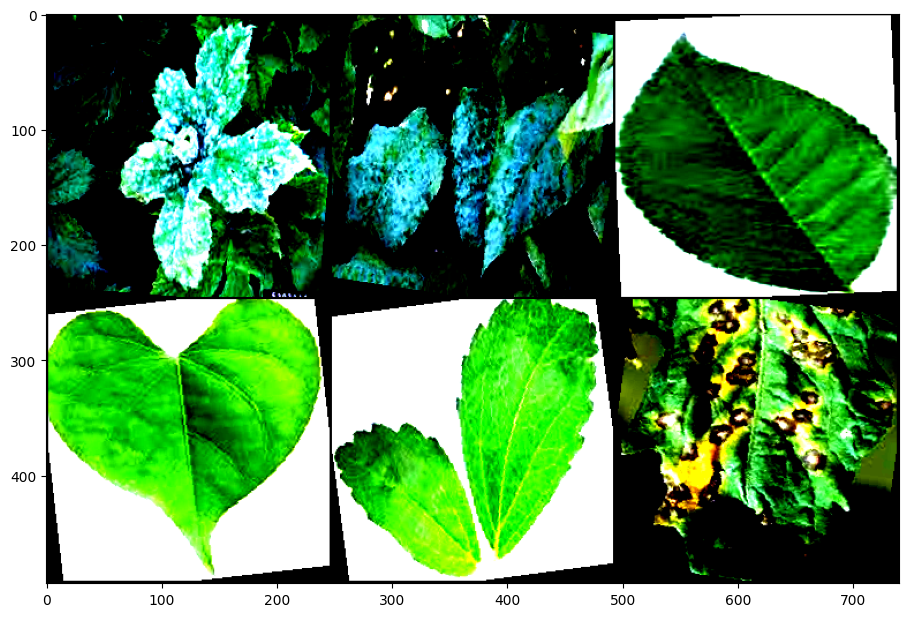

In [21]:
temp_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transform)
show_transformed_images(temp_dataset)

In [22]:
import torch
import torchvision
from torchvision import transforms

def create_data_loaders(train_dataset_path, test_dataset_path, train_transform, test_transform, batch_size=32):
    """
    Tạo các đối tượng DataLoader cho dữ liệu huấn luyện và kiểm tra.

    Parameters:
        train_dataset_path (str): Đường dẫn đến thư mục chứa dữ liệu huấn luyện.
        test_dataset_path (str): Đường dẫn đến thư mục chứa dữ liệu kiểm tra.
        train_transform (transforms.Compose): Đối tượng biến đổi dữ liệu cho dữ liệu huấn luyện.
        test_transform (transforms.Compose): Đối tượng biến đổi dữ liệu cho dữ liệu kiểm tra.
        batch_size (int, optional): Kích thước batch. Mặc định là 32.

    Returns:
        train_loader (torch.utils.data.DataLoader): DataLoader cho dữ liệu huấn luyện.
        test_loader (torch.utils.data.DataLoader): DataLoader cho dữ liệu kiểm tra.
    """
    # Tạo đối tượng ImageFolder từ đường dẫn dữ liệu huấn luyện và kiểm tra
    train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transform)
    test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transform)
    
    # Tạo DataLoader cho dữ liệu huấn luyện và kiểm tra
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader = create_data_loaders(train_dataset_path, test_dataset_path, train_transform, test_transform)


In [23]:
def save_checkpoint(models, epoch, optimizer, best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : models.state_dict(),
        'best accuracy' : optimizer.state_dict(),
        'comments' : 'Verry coll model',
    }
    torch.save(state, './model_best_checkpoint.pth.tar')

In [24]:
import torch.utils
import torch.utils.data


def evaluate_model_on_test_set(model: torch.nn.Module, 
                               test_loader: torch.utils.data.DataLoader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))
    return epoch_acc
    

In [25]:
def train_nn(model: torch.nn.Module, 
             train_loader: torch.utils.data.DataLoader, 
             test_loader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module, 
             optimizer: torch.optim.Optimizer, 
             n_epochs):
    
    best_acc = 98
    
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            total += labels.size(0)
            #reset đạo hàm
            optimizer.zero_grad()
            #output với trọng số hiện tại
            outputs = model(images)
            #lấy giá trị output theo nhãn
            _, predicted = torch.max(outputs.data, 1)
            #tính loss hiện tại
            loss = loss_fn(outputs, labels)
            #đạo hàm loss
            loss.backward()
            # SGD
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
        
        if test_dataset_acc > best_acc:
            best_acc = test_dataset_acc
            print("found better accuracy")
            save_checkpoint(model, epoch, optimizer, best_acc)
        
    print("Finished")
    return model

In [26]:
import torchvision.models as models

def initialize_resnet18_model(num_classes, pretrained=True, lr=0.01, momentum=0.9, weight_decay=0.003):
    """
    Khởi tạo mô hình ResNet-18 cho bài toán phân loại với số lớp đầu ra được chỉ định.

    Parameters:
        num_classes (int): Số lớp đầu ra (số lớp phân loại).
        pretrained (bool, optional): Sử dụng mô hình được huấn luyện trước hay không. Mặc định là True.
        lr (float, optional): Tốc độ học của bộ tối ưu hóa. Mặc định là 0.01.
        momentum (float, optional): Tham số momentum của bộ tối ưu hóa SGD. Mặc định là 0.9.
        weight_decay (float, optional): Hệ số giảm trọng lượng của bộ tối ưu hóa. Mặc định là 0.003.

    Returns:
        model (torch.nn.Module): Mô hình ResNet-18 đã được khởi tạo.
        criterion (torch.nn.Module): Hàm mất mát (loss function).
        optimizer (torch.optim.Optimizer): Bộ tối ưu hóa được sử dụng cho huấn luyện.
    """
    # Khởi tạo mô hình ResNet-18
    model = models.resnet18(pretrained=pretrained)
    
    # Thay đổi lớp cuối cùng (fully connected layer) để phù hợp với số lớp đầu ra mới
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Định nghĩa hàm mất mát (cross entropy loss)
    criterion = nn.CrossEntropyLoss()
    
    # Khởi tạo bộ tối ưu hóa (SGD)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    return model, criterion, optimizer

# Sử dụng hàm để khởi tạo mô hình ResNet-18 và các thành phần liên quan
number_of_classes = 3
resnet18_model, loss_fn, optimizer = initialize_resnet18_model(num_classes=number_of_classes)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch number 1
    - Training dataset. Got 232 out of 320 images correctly (72.500%). Epoch loss: 0.604
    - Testing dataset. Got 59 out of 60 images correctly (98.333%)
found better accuracy
Epoch number 2
    - Training dataset. Got 316 out of 320 images correctly (98.750%). Epoch loss: 0.036
    - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 3
    - Training dataset. Got 318 out of 320 images correctly (99.375%). Epoch loss: 0.018
    - Testing dataset. Got 59 out of 60 images correctly (98.333%)
Epoch number 4
    - Training dataset. Got 320 out of 320 images correctly (100.000%). Epoch loss: 0.005
    - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 5
    - Training dataset. Got 317 out of 320 images correctly (99.062%). Epoch loss: 0.034
    - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 6


KeyboardInterrupt: 

In [ ]:
number_of_classes = 3
resnet18_model, loss_fn, optimizer = initialize_resnet18_model(num_classes=number_of_classes, pretrained=True)


c:\Users\tienn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tienn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\tienn/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:13<00:00, 3.57MB/s]


In [ ]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20)

Epoch number 1
    - Training dataset. Got 185 out of 275 images correctly (67.273%). Epoch loss: 0.842
   - Testing dataset. Got 50 out of 60 images correctly (83.333%)
Epoch number 2
    - Training dataset. Got 261 out of 275 images correctly (94.909%). Epoch loss: 0.197
   - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 3
    - Training dataset. Got 267 out of 275 images correctly (97.091%). Epoch loss: 0.087
   - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 4
    - Training dataset. Got 273 out of 275 images correctly (99.273%). Epoch loss: 0.033
   - Testing dataset. Got 56 out of 60 images correctly (93.333%)
Epoch number 5
    - Training dataset. Got 274 out of 275 images correctly (99.636%). Epoch loss: 0.023
   - Testing dataset. Got 58 out of 60 images correctly (96.667%)
Epoch number 6
    - Training dataset. Got 274 out of 275 images correctly (99.636%). Epoch loss: 0.011
   - Testing dataset. Got 58 out of 60 images 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
checkpoint = torch.load('./model_best_checkpoint.pth.tar')

In [33]:
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best accuracy'])

1
Verry coll model
{'state': {0: {'momentum_buffer': tensor([[[[ 3.3750e-02,  2.9592e-02,  3.1241e-02,  ...,  3.7707e-02,
            2.7662e-02,  6.5991e-03],
          [ 4.1394e-02,  3.5139e-02,  3.1949e-02,  ...,  2.8229e-02,
            1.6361e-02,  3.4540e-03],
          [ 3.8237e-02,  3.4263e-02,  3.7403e-02,  ...,  3.5680e-02,
            1.9345e-02,  3.4119e-03],
          ...,
          [ 3.3052e-02,  3.2716e-02,  4.0895e-02,  ...,  2.3923e-02,
            9.3059e-03, -6.3205e-03],
          [ 3.6753e-02,  4.1018e-02,  5.1381e-02,  ...,  4.2651e-02,
            2.4106e-02,  4.2220e-04],
          [ 3.8272e-02,  4.3025e-02,  5.2041e-02,  ...,  2.7164e-02,
            9.5314e-03, -4.8468e-03]],

         [[ 4.3222e-02,  4.0777e-02,  4.3237e-02,  ...,  4.8066e-02,
            3.7582e-02,  1.2299e-02],
          [ 5.1802e-02,  4.6860e-02,  4.4808e-02,  ...,  3.9195e-02,
            2.6413e-02,  9.4670e-03],
          [ 4.7506e-02,  4.6493e-02,  5.2194e-02,  ...,  5.0076e-02,
     

In [34]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 3
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, './best_model.pth')